<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/5_GBC_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация Gradient Boosting Classifier (GBC) для классификации узлов в датасете Bitcoin-OTC с использованием Scikit-learn

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

Этот подход демонстрирует, как применять классические методы машинного обучения к графовым данным через feature engineering.

## 1. Установка зависимостей

In [1]:
!pip install -q torch-geometric  # Для загрузки датасета

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00


## 2. Импорт библиотек


In [2]:
import numpy as np
import torch
from torch_geometric.datasets import BitcoinOTC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3. Загрузка и подготовка данных


In [3]:
dataset = BitcoinOTC(root='data/BitcoinOTC', edge_window_size=10)
data = dataset[0]

Extracting data/BitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


## 4. Создание признаков для узлов


Признаки узлов:

* Степень узла (количество исходящих связей)
* Среднее значение входящих связей
* Среднее значение исходящих связей
* Минимальное значение входящих связей
* Максимальное значение исходящих связей

In [4]:
def prepare_features(data):
    # Признаки узлов: степень + статистики по рёбрам
    num_nodes = data.num_nodes

    # Инициализация фичей
    node_features = np.zeros((num_nodes, 5))  # [degree, mean_in, mean_out, min_in, max_out]

    # Расчёт степени узлов
    degrees = np.zeros(num_nodes)
    edge_attrs = [[] for _ in range(num_nodes)]

    # Сбор данных по рёбрам
    for i in range(data.edge_index.shape[1]):
        src = data.edge_index[0, i].item()
        dst = data.edge_index[1, i].item()
        attr = data.edge_attr[i].item()

        degrees[src] += 1  # Исходящая степень
        edge_attrs[src].append(attr)  # Исходящие рёбра
        edge_attrs[dst].append(attr)  # Входящие рёбра

    # Заполнение признаков
    for i in range(num_nodes):
        # Степень узла
        node_features[i, 0] = degrees[i]

        # Статистики по входящим рёбрам
        incoming = [attr for j, attr in enumerate(data.edge_attr) if data.edge_index[1, j] == i]
        node_features[i, 1] = np.mean(incoming) if incoming else 0
        node_features[i, 3] = np.min(incoming) if incoming else 0

        # Статистики по исходящим рёбрам
        outgoing = [attr for j, attr in enumerate(data.edge_attr) if data.edge_index[0, j] == i]
        node_features[i, 2] = np.mean(outgoing) if outgoing else 0
        node_features[i, 4] = np.max(outgoing) if outgoing else 0

    return node_features


## 5. Подготовка данных


In [5]:
X = prepare_features(data)
y = np.zeros(data.num_nodes)

### 5.1 Создание меток (3 класса на основе степени узла)

In [6]:
degrees = X[:, 0]
q1 = np.quantile(degrees, 0.33)
q2 = np.quantile(degrees, 0.66)
y[degrees > q2] = 2
y[(degrees > q1) & (degrees <= q2)] = 1

## 6. Предобработка данных


Стандартизация признаков (StandardScaler)



In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 7. Разделение данных

Стратифицированное разбиение данных

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## 8. Создание и обучение модели

Параметры GBC:
* 200 деревьев
* Глубина деревьев: 5
* Скорость обучения: 0.1
* Субсэмплинг: 80%

In [9]:
gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42,
                           subsample=0.8)

## 9. Оценка модели

Отчёт классификации содержит precision, recall и F1-score для каждого класса.
Можно экспериментировать с гиперпараметрами для улучшения результатов

In [10]:
y_pred = gbc.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1198
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00      1201
   macro avg       1.00      1.00      1.00      1201
weighted avg       1.00      1.00      1.00      1201


Test Accuracy: 1.0000


## 10. Визуализация важности признаков

Важность признаков покажет, какие характеристики наиболее значимы для классификации

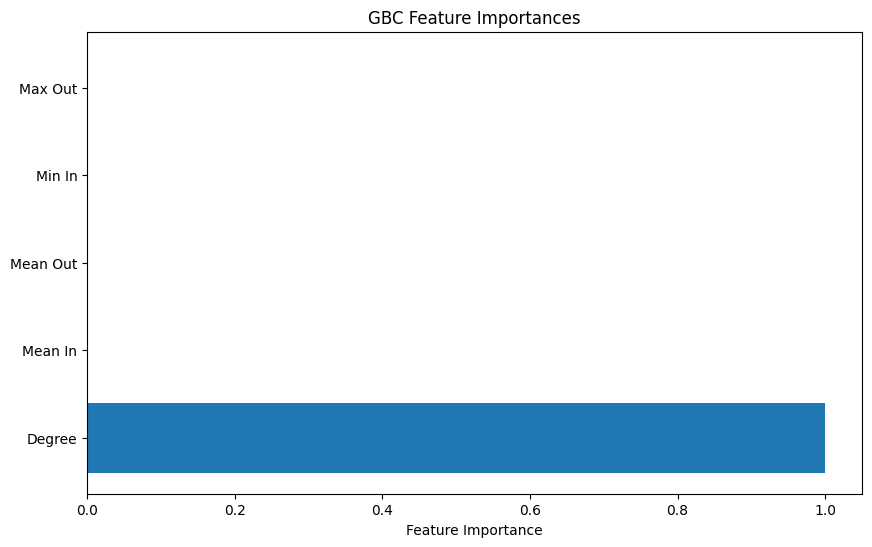

In [11]:
import matplotlib.pyplot as plt

feature_names = ['Degree', 'Mean In', 'Mean Out', 'Min In', 'Max Out']
importances = gbc.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Feature Importance")
plt.title("GBC Feature Importances")
plt.show()